In [1]:
from pathlib import Path
import pysco
import pandas as pd
import numpy as np
from astropy.constants import G, M_sun, pc
import astropy.units as u
from scipy.integrate import quad
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from astropy.cosmology import Flatw0waCDM

In [3]:
def a_to_z(a):
    if a < 0:
        raise ValueError(f"a = {a} is invalid.")
    a0 = 1
    z = a0/a - 1
    return z

def z_to_a(z):
    # blueshift -1 < z < 0 is future, a > 1
    # z > 0 is past, 0 < a < 1
    if z < -1:
        raise ValueError(f"z = {z} is invalid.")
    a0 = 1
    a = a0 / (1+z)
    return a

def proper_to_co(r, a=1): # use of relation in Zhao 2010
    if len(r) != len(a):
        raise Exception('r and a must have the same shape')
    x = r / a
    return x

def co_to_proper(x1, x2, a=1):
    if len(x1-x2) != len(a):
        raise Exception('x and a must have the same shape')
    r12 = np.abs(x1-x2)*a
    return r12

def find_boxlen_in_Mpc_over_h(om_m, mass, H0=70.0):
    """
    Calculate the cubic box size (side length in proper unit in Mpc/h) that gives a desired Ωₘ at current time.

    Parameters:
    - om_m: float
        Desired matter density fraction Ωₘ.
    - mass: float
        Total mass inside the cube (in solar masses).
    - H0: float
        Hubble constant in km/s/Mpc (default 70).

    Returns:
    - size_in_Mpc: float
        Side length of the cube in Mpc/h (at z=0 proper = comoving).
    """
    if om_m <= 0:
        raise ValueError("Ωₘ must be positive.")
    if mass <= 0:
        raise ValueError("Mass must be positive.")

    h = H0 / 100.0
    # Convert H0 to s^-1
    mpc_to_km = 1e3 * pc.value      # numerically = 1 Mpc in km
    H0_si = H0 / mpc_to_km          # km/s/Mpc ÷ (km/Mpc) = 1/s

    # Critical density (Msun/Mpc^3)
    rho_crit = (3 * H0_si**2) / (8 * np.pi * G.value)
    rho_crit *= (1 / M_sun.value) * (mpc_to_km * 1e3)**3

    # Solve for box size
    size_in_Mpc = (mass / (om_m * rho_crit))**(1/3)
    size_in_Mpc_over_h = size_in_Mpc * h
    print(f"Expected box size = {size_in_Mpc_over_h:.3f} Mpc/h for a Ωₘ={om_m:.5f} universe")
    return size_in_Mpc_over_h


def find_om_m(size_in_Mpc, mass, H0=70.):
    """
    Calculate the matter density fraction (Ωₘ) of universe given its size and mass.
    
    Parameters:
    - size_in_Mpc: assume a cubic volume, size is the proper length (in Mpc).
    - mass: total mass inside the volume (in solar masses).
    - H0: Hubble constant in km/s/Mpc.
    
    Returns:
    - Density in Msun/Mpc^3.
    """
    if size_in_Mpc <= 0:
        raise ValueError("Each side must be greater than zero.")
    if mass <= 0:
        raise ValueError("Total mass must be greater than zero.")
    
    print(f'total mass = {mass:.2E} MSun in a {size_in_Mpc} Mpc = {size_in_Mpc*(H0/100)} Mpc/h box')
    # compute rho_m
    volume = size_in_Mpc ** 3
    rho_m = mass / volume  # Msun/Mpc^3
    rho_m = rho_m
    mpc_to_km = 1e3 * pc.value  # Mpc -> km
    H0 = H0 / mpc_to_km  # km/s/Mpc -> 1/s
    rho_crit = 3 * H0**2 / (8*np.pi*G.value) # critical density in kg/m³
    rho_crit = rho_crit / M_sun.value * (mpc_to_km*1e3)**3 # Msun/Mpc^3

    om_m = rho_m / rho_crit  # Ωₘ
    print(f'Ωₘ={om_m:.5f}')
    return om_m

def cosmic_time_from_z(z, omh_m=1/3, H0=70.0):
    """
    Return the cosmic time (in Gyr) at a given redshift z for a flat universe.

    Parameters
    ----------
    z : float
        Redshift.
    omh_m : float, optional
        Matter density parameter Ωₘ.
    H0 : float, optional
        Hubble constant in km/s/Mpc. Default is 70.

    Returns
    -------
    t_z : float
        Cosmic time at redshift z in Gyr.
    """
    mpc_to_km = 1e3 * pc.value
    H0_si = H0 / mpc_to_km # H0 in 1/s

    def E(zp): # E(z) = H(z)/H0
        return np.sqrt(omh_m*(1+zp)**3 + (1-omh_m))
    to_be_integrated = lambda zp: 1.0 / ((1 + zp) * E(zp)) # integrate 1/[(1+z)E(z)]
    time, _ = quad(to_be_integrated, z, np.inf) # Integrate from z to ∞ (Big Bang)
    sec_per_Gyr = 3.15576e16
    time = time / H0_si / sec_per_Gyr
    return time

def z_from_time(t_Gyr, omh_m=1/3, H0=70.0, z_upper=1e5):
    """
    Invert cosmic time -> redshift for flat ΛCDM without calling time_from_z.

    Parameters
    ----------
    t_Gyr : float
        Cosmic time since the Big Bang (in Gyr). Must satisfy 0 < t_Gyr <= t0.
    omh_m : float
        Ω_m (matter density parameter today).
    H0 : float
        Hubble constant in km/s/Mpc (default 70).
    z_upper : float
        Upper bound for the redshift bracket in root finding.

    Returns
    -------
    z : float
        Redshift corresponding to the input cosmic time.
    """
    # Unit conversions
    mpc_to_km = 1e3 * pc.value          # 1 Mpc in km
    H0_si = H0 / mpc_to_km              # H0 in s^-1
    sec_per_Gyr = 3.15576e16            # seconds in a Gyr

    # E(z) = H(z)/H0 for flat ΛCDM (no radiation/curvature)
    def E(z):
        return np.sqrt(omh_m * (1.0 + z)**3 + (1-omh_m))

    # Local definition of cosmic time t(z) (in Gyr), from z to ∞
    def t_of_z(z):
        integrand = lambda zp: 1.0 / ((1.0 + zp) * E(zp))
        integral, _ = quad(integrand, z, np.inf)
        return integral / H0_si / sec_per_Gyr

    # Edge cases
    if t_Gyr <= 0:
        return np.inf  # t -> 0 corresponds to z -> ∞

    #t0 = t_of_z(0.0)   # present age
    #if t_Gyr >= t0:
    #    return 0.0     # at/after today → z = 0

    # Root: f(z) = t(z) - t_Gyr ; want f(z) = 0 with z in [0, z_upper]
    f = lambda z: t_of_z(z) - t_Gyr

    # Ensure the upper bracket gives f(z_upper) < 0 (i.e., t(z_upper) < t_Gyr)
    f_hi = f(z_upper)
    if f_hi > 0:
        # expand if needed
        for factor in (1e6, 1e8):
            z_try = z_upper * factor
            if f(z_try) < 0:
                z_upper = z_try
                break
        else:
            raise RuntimeError("Failed to bracket the root; try larger z_upper or check parameters.")


    # Brent root finder (robust and fast)
    z = brentq(f, 0.0, z_upper)
    return z

In [3]:
"""
current_age = 14
cosmic_time = np.linspace(0, 14, 20)
z = []
om_m = 1/3
for t in cosmic_time:
    z.append(z_from_time(t, om_m))
look_back_time = cosmic_time - current_age
plt.plot(look_back_time, z, 'x', label=f'om_m={om_m:.3f}')
plt.legend(fontsize=13)
plt.ylabel('z(t)', fontsize=13)
plt.xlabel('look back time (Gyr)', fontsize=13)
plt.show()
z, look_back_time
"""

"\ncurrent_age = 14\ncosmic_time = np.linspace(0, 14, 20)\nz = []\nom_m = 1/3\nfor t in cosmic_time:\n    z.append(z_from_time(t, om_m))\nlook_back_time = cosmic_time - current_age\nplt.plot(look_back_time, z, 'x', label=f'om_m={om_m:.3f}')\nplt.legend(fontsize=13)\nplt.ylabel('z(t)', fontsize=13)\nplt.xlabel('look back time (Gyr)', fontsize=13)\nplt.show()\nz, look_back_time\n"

# Set main parameters

In [ ]:
# cosmology parameters 
# H²(t) = H₀² [Ωₘ a⁻³ + ΩΛ]
#Om_m = find_om_m(size_in_Mpc=10, mass=(m_MW+m_M31))

H0 = 70         # km/s/Mpc
h = H0/100      # no unit 
Om_m = 1/3      # Matter density parameter Ωₘ = 1/3
T_cmb = 0.      # No CMB radiation (T = 0 K means no radiation)
N_eff = 0.      # No effective neutrino species (no radiation)
w0 = -1.        # Dark energy equation of state w = -1 (cosmological constant ΩΛ)
wa = 0.         # No evolution of dark energy EoS

# Box parameters 
m_MW = 0.7e11
m_M31 = 1.6e11

# print(f'mass of MW: {m_MW:.2E} Msun')
# print(f'mass of M31: {m_M31:.2E} Msun')
boxlen = find_boxlen_in_Mpc_over_h(om_m=Om_m, mass=(m_MW+m_M31)) # in Mpc/h

# force law
theory = "mond"

Om_m = find_om_m(size_in_Mpc=boxlen/h, mass=(m_MW+m_M31))
print('Ωₘ:', Om_m)
print(f'boxlen:{boxlen:.3f}', 'Mpc/h')

Expected box size = 1.019 Mpc/h for a Ωₘ=0.33333 universe
total mass = 1.40E+11 MSun in a 1.4562780426003694 Mpc = 1.0193946298202585 Mpc/h box
Ωₘ=0.33333
Ωₘ: 0.3333333333333333
boxlen:1.019 Mpc/h


In [ ]:
"""
# choose redshift at which to output snapshots
cosmic_time = np.linspace(14, 0, 50)
z = np.zeros(len(cosmic_time))

for i in range(0, len(cosmic_time)):
    z[i] = z_from_time(cosmic_time[i], Om_m)


fig, ax1 = plt.subplots(figsize=(6.5, 4))

# Left y-axis: z(t)
ln1 = ax1.plot(cosmic_time-13.7, z, 'x')
ln1 = ax1.plot(cosmic_time-13.7, z, linestyle='-', label='z(t)', color='tab:blue')
ax1.set_xlabel('look back time (Gyr)')
ax1.set_ylabel('z(t)')

# Right y-axis: a(t)
ax2 = ax1.twinx()
ln2 = ax2.plot(cosmic_time-13.7, 1/(1+z), linestyle='-', label='a(t)', color='tab:orange')
ax2.set_ylabel('a(t)')

# One legend for both
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')

plt.title(f'om_m0 ={Om_m:.2f}')
plt.tight_layout()
plt.show()

cosmic_time = cosmic_time[(np.isfinite(z)) & (z>0)]
z = z[(np.isfinite(z)) & (z>0)] 
z_start = 0
z_out = z[:-1]
print('Ωₘ:', Om_m)
print('boxlen:', boxlen, 'Mpc/h')
print(f'start z: {z_start}')
print(f'output z: {z_out}')"""

"\nfor i in range(0, len(cosmic_time)):\n    z[i] = z_from_time(cosmic_time[i], Om_m)\n\n\nfig, ax1 = plt.subplots(figsize=(6.5, 4))\n\n# Left y-axis: z(t)\nln1 = ax1.plot(cosmic_time-13.7, z, 'x')\nln1 = ax1.plot(cosmic_time-13.7, z, linestyle='-', label='z(t)', color='tab:blue')\nax1.set_xlabel('look back time (Gyr)')\nax1.set_ylabel('z(t)')\n\n# Right y-axis: a(t)\nax2 = ax1.twinx()\nln2 = ax2.plot(cosmic_time-13.7, 1/(1+z), linestyle='-', label='a(t)', color='tab:orange')\nax2.set_ylabel('a(t)')\n\n# One legend for both\nlines = ln1 + ln2\nlabels = [l.get_label() for l in lines]\nax1.legend(lines, labels, loc='best')\n\nplt.title(f'om_m0 ={Om_m:.2f}')\nplt.tight_layout()\nplt.show()\n\ncosmic_time = cosmic_time[(np.isfinite(z)) & (z>0)]\nz = z[(np.isfinite(z)) & (z>0)] \nz_start = 0\nz_out = z[:-1]\nprint('Ωₘ:', Om_m)\nprint('boxlen:', boxlen, 'Mpc/h')\nprint(f'start z: {z_start}')\nprint(f'output z: {z_out}')"

# go to future
negative z

In [5]:
def compute_future_cosmo(Om_m=1/3, H0=70.0, w0=-1.0, wa=0.0,
                         t_future_max_gyr=30.0, n_samples=100_000):
    """
    Compute future evolution arrays a(t), E(a)=H/H0, and time since today (Gyr)
    for a flat w0waCDM cosmology. Today is t=0 at a=1 (z=0).

    Parameters
    ----------
    Om_m : float
        Present-day matter density parameter Ω_m.
    H0 : float
        Hubble constant in km/s/Mpc.
    w0, wa : float
        Dark-energy EoS parameters (w(a) = w0 + wa(1-a)).
        For ΛCDM use w0=-1, wa=0.
    t_future_max_gyr : float
        How far into the future to integrate (in Gyr).
    n_samples : int
        Number of samples for the ln a grid.

    Returns
    -------
    a : ndarray
        Scale-factor samples from a=1 into the future (a >= 1).
    E_array : ndarray
        E(a) = H(a)/H0 sampled on the same grid as `a`.
    t_future_gyr : ndarray
        Time since today (t=0 at a=1) in Gyr for each `a`.
    """
    # Cosmology (radiation neglected for future)
    cosmo = Flatw0waCDM(H0=H0, Om0=Om_m, Tcmb0=0.0, Neff=0.0, w0=w0, wa=wa)
    Om_L = 1.0 - Om_m

    # Units
    H0_si = H0 / (1e3 * pc.value)     # s^-1
    sec_per_Gyr = 3.15576e16

    # Rough a_max using de Sitter asymptotics: a ~ exp(H_Λ Δt)
    H_deS = float(H0_si) * np.sqrt(Om_L)   # s^-1
    a_max_guess = float(np.exp(H_deS * (t_future_max_gyr * sec_per_Gyr)))
    # ln a grid from today (ln a = 0) to future
    lna = np.linspace(0.0, np.log(a_max_guess), int(n_samples))
    a = np.exp(lna)

    # E(a) = H/H0 via astropy (z = 1/a - 1)
    z_grid = 1.0 / a - 1.0
    E_array = cosmo.efunc(z_grid)  # dimensionless

    # H0 * Δt(a) = ∫ d ln a / E(a); set Δt(1)=0 at lna=0
    t_dimless = cumulative_trapezoid(1.0 / E_array, lna, initial=0.0)
    t_future_gyr = t_dimless / float(H0_si) / sec_per_Gyr  # time since today

    # Trim to the requested future time horizon
    mask = t_future_gyr <= t_future_max_gyr
    a = a[mask]
    E_array = E_array[mask]
    t_future_gyr = t_future_gyr[mask]

    return a, E_array, t_future_gyr

"""
t_future_max_gyr = 15

a, E_array, t_future_gyr = compute_future_cosmo(Om_m = Om_m, t_future_max_gyr=t_future_max_gyr)
z = 1.0/np.asarray(a) - 1.0

fig, ax1 = plt.subplots(figsize=(6.5, 4))

# Left y-axis: z(t)
ln1 = ax1.plot(t_future_gyr, z, linestyle='-', label='z(t)')
ax1.set_xlabel('Future time (Gyr)')
ax1.set_ylabel('z(t)')
ax1.axhline(0.0, ls='--', lw=1, alpha=0.4)

# Right y-axis: a(t)
ax2 = ax1.twinx()
ln2 = ax2.plot(t_future_gyr, a, linestyle='-', label='a(t)', color='tab:orange')
ax2.set_ylabel('a(t)')

# One legend for both
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')
plt.title(f'Flatw0waCDM model: om_m0 ={Om_m:.2f}')
plt.tight_layout()
plt.show()

a, _, t_future_gyr = compute_future_cosmo(t_future_max_gyr=t_future_max_gyr, n_samples=150)
z_out = 1.0/np.asarray(a) - 1.0
z_out = z_out[1:]
print("z_out:",z_out)
"""

'\nt_future_max_gyr = 15\n\na, E_array, t_future_gyr = compute_future_cosmo(Om_m = Om_m, t_future_max_gyr=t_future_max_gyr)\nz = 1.0/np.asarray(a) - 1.0\n\nfig, ax1 = plt.subplots(figsize=(6.5, 4))\n\n# Left y-axis: z(t)\nln1 = ax1.plot(t_future_gyr, z, linestyle=\'-\', label=\'z(t)\')\nax1.set_xlabel(\'Future time (Gyr)\')\nax1.set_ylabel(\'z(t)\')\nax1.axhline(0.0, ls=\'--\', lw=1, alpha=0.4)\n\n# Right y-axis: a(t)\nax2 = ax1.twinx()\nln2 = ax2.plot(t_future_gyr, a, linestyle=\'-\', label=\'a(t)\', color=\'tab:orange\')\nax2.set_ylabel(\'a(t)\')\n\n# One legend for both\nlines = ln1 + ln2\nlabels = [l.get_label() for l in lines]\nax1.legend(lines, labels, loc=\'best\')\nplt.title(f\'Flatw0waCDM model: om_m0 ={Om_m:.2f}\')\nplt.tight_layout()\nplt.show()\n\na, _, t_future_gyr = compute_future_cosmo(t_future_max_gyr=t_future_max_gyr, n_samples=150)\nz_out = 1.0/np.asarray(a) - 1.0\nz_out = z_out[1:]\nprint("z_out:",z_out)\n'

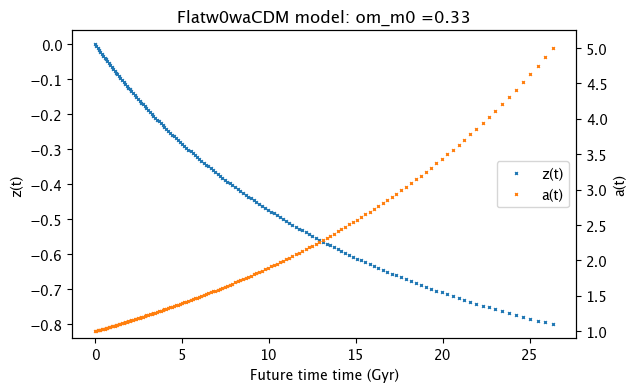

z_out: [-0.00536913 -0.01073826 -0.01610738 -0.02147651 -0.02684564 -0.03221477
 -0.03758389 -0.04295302 -0.04832215 -0.05369128 -0.0590604  -0.06442953
 -0.06979866 -0.07516779 -0.08053691 -0.08590604 -0.09127517 -0.0966443
 -0.10201342 -0.10738255 -0.11275168 -0.11812081 -0.12348993 -0.12885906
 -0.13422819 -0.13959732 -0.14496644 -0.15033557 -0.1557047  -0.16107383
 -0.16644295 -0.17181208 -0.17718121 -0.18255034 -0.18791946 -0.19328859
 -0.19865772 -0.20402685 -0.20939597 -0.2147651  -0.22013423 -0.22550336
 -0.23087248 -0.23624161 -0.24161074 -0.24697987 -0.25234899 -0.25771812
 -0.26308725 -0.26845638 -0.2738255  -0.27919463 -0.28456376 -0.28993289
 -0.29530201 -0.30067114 -0.30604027 -0.3114094  -0.31677852 -0.32214765
 -0.32751678 -0.33288591 -0.33825503 -0.34362416 -0.34899329 -0.35436242
 -0.35973154 -0.36510067 -0.3704698  -0.37583893 -0.38120805 -0.38657718
 -0.39194631 -0.39731544 -0.40268456 -0.40805369 -0.41342282 -0.41879195
 -0.42416107 -0.4295302  -0.43489933 -0.44026

In [6]:
# from astropy.cosmology import Planck18
# Age of Universe today (z = 0)
# t0 = Planck18.age(0)
# print(f'Age of Universe today: {t0:.3f}')

cosmo = Flatw0waCDM(
        H0=H0,
        Om0=Om_m,
        Tcmb0=T_cmb,
        Neff=N_eff,
        w0=w0,
        wa=wa,
    )
z_max = -0.8
nsamples = 150
z_grid = np.linspace(0.0, z_max, nsamples)
a_grid = 1.0 / (1.0 + z_grid)

t0 = cosmo.age(0).to(u.Gyr).value  # Age of Universe today (Gyr) in my cosmology
# Cosmic time from Astropy (Gyr)
t_Gyr = cosmo.age(z_grid).to(u.Gyr).value

# make the plot
fig, ax1 = plt.subplots(figsize=(6.5, 4))

# Left y-axis: z(t)
ln1 = ax1.plot(t_Gyr-t0, z_grid, 'x', markersize=2, label='z(t)', color='tab:blue')
ax1.set_xlabel('Future time time (Gyr)')
ax1.set_ylabel('z(t)')

# Right y-axis: a(t)
ax2 = ax1.twinx()
ln2 = ax2.plot(t_Gyr-t0, a_grid,  'x', markersize=2, label='a(t)', color='tab:orange')
ax2.set_ylabel('a(t)')
ax2.set_ylim(0.9, np.max(a_grid)*1.05)

# One legend for both
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=7)

plt.title(f'Flatw0waCDM model: om_m0 ={Om_m:.2f}')
plt.axhline(0.0, ls='--', lw=1, alpha=0.4)
plt.show()

z_start = 0
z_out = z_grid[1:]
print("z_out:",z_out)

## Generate initial condition

In [7]:
def find_com(pos, vel, m1, m2, boxsize=10.): # convert to CoM frame
    """
    Transform 2-body positions and velocities into the CoM frame,
    then shift so the barycenter is at the center of the simulation box.

    Parameters
    ----------
    pos : ndarray shape (2, 3)
        Positions of the two bodies in any frame [kpc]
    vel : ndarray shape (2, 3)
        Velocities of the two bodies in any frame [km/s]
    m1, m2 : float
        Masses of the two bodies [same units]
    boxsize : float
        Physical size of the simulation box [Mpc]

    Returns
    -------
    pos_box : ndarray shape (2, 3)
        Positions in the CoM frame shifted to box center [kpc]
    vel_com : ndarray shape (2, 3)
        Velocities in the CoM frame [km/s]
    """
    
    pos = np.asarray(pos, dtype=np.float64)
    vel = np.asarray(vel, dtype=np.float64)
    Mtot = m1+m2
    r_com = (m1*pos[0] + m2*pos[1]) / Mtot
    v_com = (m1*vel[0] + m2*vel[1]) / Mtot
    pos_com = pos - r_com # shift to CoM frame
    vel_com = vel - v_com
    print(pos_com, vel_com)
    box_center = boxsize/2 * 1e3 # box centre in kpc
    box_center_vec = np.array([box_center]*3)  # Compute box center vector
    pos_box = pos_com + box_center_vec # Shift CoM to box center
    print(f'box has size: {boxsize:.3f} Mpc')
    print(f'm1 pos: {pos_box[0, :]/1e3} Mpc, vel: {vel_com[0, :]} km/s')
    print(f'm2 pos: {pos_box[1, :]/1e3} Mpc, vel: {vel_com[1, :]} km/s')
    return pos_box, vel_com

# put particles at the centre of box
positions = np.array([
    [0., 0., 0.],       # Particle 1 position (kpc)
    [-378., 612., -283.]       # Particle 2 position
], dtype=np.float32)

velocities = np.array([
    [0., 0., 0.],     # Particle 1 velocity (km/s)
    #[60.4, -82.7, 54.2]      # Particle 2 velocity
    [109., 17., 0.]
], dtype=np.float32)


m_MW = m_MW # Msun
m_M31 = m_M31 # Msun
boxlen_in_Mpc = boxlen / h # Mpc
pos, vel = find_com(positions, velocities, m_MW, m_M31, boxlen_in_Mpc)

# Define DataFrame with separate x, y, z columns
df = pd.DataFrame({
    "x": pos[:, 0],
    "y": pos[:, 1],
    "z": pos[:, 2],
    "vx": vel[:, 0],
    "vy": vel[:, 1],
    "vz": vel[:, 2]
})

# Save to Parquet
#path = "test_2body/galaxy_infall/mond/output_infall_0.1/output_00000/"
path = 'mw_m31/simple_test/output_00000/'
#path = 'mw_m31/standard/output_00000/'
#df.to_parquet(f"{path}particles_mond_g0_1.2_exponent_0_n_2_multigrid_ncoarse5.parquet",index=False)
df.to_parquet(f"{path}particles_mond_g0_1.2_exponent_0_simple_multigrid_ncoarse5.parquet",index=False)
#df.to_parquet(f"{path}particles_newton_multigrid_ncoarse5.parquet", index=False)

print(f"✅ Parquet file fixed and saved to {path}")


[[ 189.  -306.   141.5]
 [-189.   306.  -141.5]] [[-54.5  -8.5   0. ]
 [ 54.5   8.5   0. ]]
box has size: 1.456 Mpc
m1 pos: [0.91713902 0.42213902 0.86963902] Mpc, vel: [-54.5  -8.5   0. ] km/s
m2 pos: [0.53913902 1.03413902 0.58663902] Mpc, vel: [54.5  8.5  0. ] km/s
✅ Parquet file fixed and saved to mw_m31/simple_test/output_00000/


In [8]:
#path = Path(__file__).parent.absolute()

import os
path = os.getcwd()
path = f'{path}/mw_m31/simple_test/'

param = {
    "nthreads": 1,                    # Use 1 CPU thread. (Can be >1 if you want parallelism.)
    "theory": theory,                 # "newton" or "mond"
    "mond_function": "simple",       
    "mond_g0": 1.2,                  # dimensionless
    "mond_scale_factor_exponent": 0,
    "mond_alpha": 1,
    "H0": H0,                               # km/s/Mpc
    "Om_m": Om_m,                       # Matter density fraction (Ωₘ)
    "T_cmb": T_cmb,                          # CMB temperature in Kelvin — defines radiation energy density.
    "N_eff": N_eff,                            # Effective number of relativistic species (neutrinos). Usually not used in 2-body sims.
    "w0": w0,
    "wa": wa,                              # ΛCDMmodel

    # Simulation dimension
    "boxlen": boxlen,           # in Mpc/h
    "ncoarse": 5,                     # ncells_1d = 2^ncoarse
    "npart": 2,        
    
    # Initial conditions
    "z_start": z_start,                     # Initial redshift for the simulation
    "seed": 42,             
    "position_ICS": "center",            # Initial particle positions: "center" or "random"
    "initial_conditions": 00000,                                    # Irrelevant here since not generating Gaussian ICs
    "write_snapshot": True,          # Write initial snapshot to file

    # Outputs
    "base": path,    # Base output directory
    "output_snapshot_format": "parquet",
    "z_out": str("[" + ", ".join(f"{val:.4f}" for val in z_out) + "]"), 
    "save_power_spectrum": "no",

    # Particles
    "integrator": "leapfrog",               # Integration scheme for time-stepping "Leapfrog" or "Euler"
    "mass_scheme": "TSC",                   # TSC: mass is spread to the 27 nearest grid points (3×3×3 cube) -- kernel to assign particle mass across nearby grid cells
    "n_reorder": 50,                        # Re-order particles every n_reorder steps 
    "mass": [m_MW, m_M31],               # in solar masses
    
    # Time stepping
    "Courant_factor": 1.0,                  # Cell fraction for time stepping based on velocity/acceleration (Courant_factor < 1 means more time steps)
    "max_aexp_stepping": 10,                # Maximum percentage [%] of scale factor that cannot be exceeded by a time step
    
    # Newtonian solver
    "linear_newton_solver": "multigrid",    # Linear solver for Newton's method: "multigrid", "fft", "fft_7pt" or "full_fft"
    "gradient_stencil_order": 5,            # n-point stencil with n = 2, 3, 5 or 7  
    
    # Multigrid
    "Npre": 2,                          # Number of pre-smoothing Gauss-Seidel iterations
    "Npost": 1,                         # Number of post-smoothing Gauss-Seidel iterations
    "epsrel": 1e-2,                     # Maximum relative error on the residual norm
    
    # Verbose
    "verbose": 1                   # Verbose level. 0 : silent, 1 : basic infos, 2 : full timings

}

param["mass"] = pd.Series(param["mass"])


# Run simulation
param = pd.Series(param)
pysco.run(param)

print("Run completed!")


param['nthreads']=1

FFT module: PyFFTW

----- Compute background cosmology -----

Write table in: /Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College 2022-2026/Yr               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//evolution_table_pysco_mond_g0_1.2_exponent_0_simple_multigrid_
ncoarse5.txt

----- Initial conditions -----

Reading initial conditions from filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College 2022-2026/Yr 4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00000/particles_mond_g0_1.2_exponent_0_simple_multigrid_ncoarse5.parquet'


Read parquet snapshot /Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College 2022-2026/Yr         
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00000/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet

Write initial snapshot...snap_name='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College        
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00000/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet'

Parameter file read at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College  
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00000/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00000.txt'


 -- Box parameters --
Universe size = 1 BU = 1.456 Mpc
particle number = 2

 -- Initial conditions --
Initial redshift = 0
Initial scale factor = 1.0
Initial lookback time = -0.000 seconds
Initial position = 
[[0.62978291 0.28987529 0.59716551]
 [0.37021709 0.71012471 0.40283449]] BU
Initial velocity = 
[[-0.53463103 -0.08338282  0.        ]
 [ 0.53463103  0.08338282  0.        ]] BU/BU time


param['aexp']=1.0 param['t']=array(-6.61595417e-05)

----- Run N-body -----

box mean density = 3.052e-05 1/BU^3 = 9.363e-23 kg/km³
 param["unit_d"] 3.067957974324174e-18
time stepping:  0.05845153
box mean density = 3.052e-05 1/BU^3 = 9.212e-23 kg/km³
 param["unit_d"] 3.0185249570107814e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00001/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00001.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00001/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0054293183189222)

param['nsteps']=1 param['aexp']=np.float64(1.0054293183189222) z = -0.005400000000000071, t = 0.0053265169403639056

time stepping:  0.05824634
box mean density = 3.052e-05 1/BU^3 = 9.065e-23 kg/km³
 param["unit_d"] 2.9705265164933673e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00002/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00002.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00002/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0108157282927324)

param['nsteps']=2 param['aexp']=np.float64(1.0108157282927324) z = -0.010700000000000154, t = 0.010604961627579925

time stepping:  0.05751314
box mean density = 3.052e-05 1/BU^3 = 8.918e-23 kg/km³
 param["unit_d"] 2.922148536873167e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00003/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00003.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00003/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0163634515702815)

param['nsteps']=3 param['aexp']=np.float64(1.0163634515702815) z = -0.016100000000000003, t = 0.015968165803764756

time stepping:  0.05617744
box mean density = 3.052e-05 1/BU^3 = 8.772e-23 kg/km³
 param["unit_d"] 2.874298685184327e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00004/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00004.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00004/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0219724067450178)

param['nsteps']=4 param['aexp']=np.float64(1.0219724067450178) z = -0.021499999999999853, t = 0.021316199176372442

time stepping:  0.054658864
box mean density = 3.052e-05 1/BU^3 = 8.630e-23 kg/km³
 param["unit_d"] 2.827845688987315e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00005/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00005.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00005/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0275380189066996)

param['nsteps']=5 param['aexp']=np.float64(1.0275380189066996) z = -0.026800000000000046, t = 0.026550252227251735

time stepping:  0.053314384
box mean density = 3.052e-05 1/BU^3 = 8.487e-23 kg/km³
 param["unit_d"] 2.781033751036969e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00006/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00006.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00006/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0332713370531101)

param['nsteps']=6 param['aexp']=np.float64(1.0332713370531101) z = -0.032200000000000006, t = 0.03186763672923466

time stepping:  0.05221913
box mean density = 3.052e-05 1/BU^3 = 8.346e-23 kg/km³
 param["unit_d"] 2.7347412990221548e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00007/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00007.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00007/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0390689941812137)

param['nsteps']=7 param['aexp']=np.float64(1.0390689941812137) z = -0.03760000000000008, t = 0.03716925601726344

time stepping:  0.05142893
box mean density = 3.052e-05 1/BU^3 = 8.206e-23 kg/km³
 param["unit_d"] 2.688965434385267e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00008/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00008.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00008/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.044932079414838)

param['nsteps']=8 param['aexp']=np.float64(1.044932079414838) z = -0.04299999999999993, t = 0.04245490859150794

time stepping:  0.050935905
box mean density = 3.052e-05 1/BU^3 = 8.070e-23 kg/km³
 param["unit_d"] 2.6445367961112417e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00009/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00009.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00009/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0507512871703268)

param['nsteps']=9 param['aexp']=np.float64(1.0507512871703268) z = -0.04830000000000001, t = 0.04762695707807634

time stepping:  0.050710157
box mean density = 3.052e-05 1/BU^3 = 7.934e-23 kg/km³
 param["unit_d"] 2.599775977819933e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00010/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00010.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00010/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0567473317129874)

param['nsteps']=10 param['aexp']=np.float64(1.0567473317129874) z = -0.05369999999999997, t = 0.05288037427856676

time stepping:  0.050653767
box mean density = 3.052e-05 1/BU^3 = 7.799e-23 kg/km³
 param["unit_d"] 2.5555231049107196e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00011/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00011.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00011/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0628122010840686)

param['nsteps']=11 param['aexp']=np.float64(1.0628122010840686) z = -0.05910000000000015, t = 0.05811722220639111

time stepping:  0.05053236
box mean density = 3.052e-05 1/BU^3 = 7.668e-23 kg/km³
 param["unit_d"] 2.5125808513916487e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00012/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00012.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00012/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0688328345446771)

param['nsteps']=12 param['aexp']=np.float64(1.0688328345446771) z = -0.0643999999999999, t = 0.06324078336681319

time stepping:  0.049955275
box mean density = 3.052e-05 1/BU^3 = 7.536e-23 kg/km³
 param["unit_d"] 2.4693259008733195e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00013/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00013.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00013/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.075037626316921)

param['nsteps']=13 param['aexp']=np.float64(1.075037626316921) z = -0.06979999999999997, t = 0.06844419742517559

time stepping:  0.048848685
box mean density = 3.052e-05 1/BU^3 = 7.405e-23 kg/km³
 param["unit_d"] 2.4265702537412596e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00014/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00014.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00014/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0813148788927336)

param['nsteps']=14 param['aexp']=np.float64(1.0813148788927336) z = -0.07520000000000004, t = 0.07363043608855833

time stepping:  0.04762599
box mean density = 3.052e-05 1/BU^3 = 7.279e-23 kg/km³
 param["unit_d"] 2.3850890961738475e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00015/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00015.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00015/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0875475802066341)

param['nsteps']=15 param['aexp']=np.float64(1.0875475802066341) z = -0.08050000000000002, t = 0.07870373284834652

time stepping:  0.046608824
box mean density = 3.052e-05 1/BU^3 = 7.151e-23 kg/km³
 param["unit_d"] 2.343314247477976e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00016/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00016.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00016/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.0939722131057872)

param['nsteps']=16 param['aexp']=np.float64(1.0939722131057872) z = -0.08590000000000009, t = 0.0838553317861993

time stepping:  0.04585012
box mean density = 3.052e-05 1/BU^3 = 7.025e-23 kg/km³
 param["unit_d"] 2.302030060172547e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00017/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00017.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00017/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1004732034774953)

param['nsteps']=17 param['aexp']=np.float64(1.1004732034774953) z = -0.09130000000000005, t = 0.0889891451772217

time stepping:  0.045380086
box mean density = 3.052e-05 1/BU^3 = 6.903e-23 kg/km³
 param["unit_d"] 2.2619847097535035e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00018/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00018.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00018/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1069293779056897)

param['nsteps']=18 param['aexp']=np.float64(1.1069293779056897) z = -0.09660000000000002, t = 0.09401039269796002

time stepping:  0.0451846
box mean density = 3.052e-05 1/BU^3 = 6.780e-23 kg/km³
 param["unit_d"] 2.2216641969295663e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00019/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00019.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00019/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1135857461024499)

param['nsteps']=19 param['aexp']=np.float64(1.1135857461024499) z = -0.10199999999999998, t = 0.0991083552568303

time stepping:  0.045209095
box mean density = 3.052e-05 1/BU^3 = 6.658e-23 kg/km³
 param["unit_d"] 2.181825703500244e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00020/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00020.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00020/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.120322652924042)

param['nsteps']=20 param['aexp']=np.float64(1.120322652924042) z = -0.10739999999999994, t = 0.10418791872078696

time stepping:  0.045282304
box mean density = 3.052e-05 1/BU^3 = 6.538e-23 kg/km³
 param["unit_d"] 2.1424663309079278e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00021/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00021.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00021/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.127141568981064)

param['nsteps']=21 param['aexp']=np.float64(1.127141568981064) z = -0.11280000000000001, t = 0.10924887734877967

time stepping:  0.044949375
box mean density = 3.052e-05 1/BU^3 = 6.422e-23 kg/km³
 param["unit_d"] 2.1042989285237502e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00022/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00022.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00022/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1339154099104207)

param['nsteps']=22 param['aexp']=np.float64(1.1339154099104207) z = -0.11809999999999998, t = 0.11419782482018172

time stepping:  0.044091754
box mean density = 3.052e-05 1/BU^3 = 6.305e-23 kg/km³
 param["unit_d"] 2.0658803630200105e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00023/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00023.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00023/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1409013120365088)

param['nsteps']=23 param['aexp']=np.float64(1.1409013120365088) z = -0.12349999999999994, t = 0.119221309825452

time stepping:  0.043108128
box mean density = 3.052e-05 1/BU^3 = 6.189e-23 kg/km³
 param["unit_d"] 2.02793227635745e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00024/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00024.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00024/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1479738261967627)

param['nsteps']=24 param['aexp']=np.float64(1.1479738261967627) z = -0.12890000000000001, t = 0.12422557534463488

time stepping:  0.042328164
box mean density = 3.052e-05 1/BU^3 = 6.076e-23 kg/km³
 param["unit_d"] 1.991141621556191e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00025/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00025.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00025/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.155001155001155)

param['nsteps']=25 param['aexp']=np.float64(1.155001155001155) z = -0.13419999999999999, t = 0.12911828191635605

time stepping:  0.041830063
box mean density = 3.052e-05 1/BU^3 = 5.963e-23 kg/km³
 param["unit_d"] 1.95411721802751e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00026/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00026.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00026/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1622501162250116)

param['nsteps']=26 param['aexp']=np.float64(1.1622501162250116) z = -0.13959999999999995, t = 0.13408385721438387

time stepping:  0.0416008
box mean density = 3.052e-05 1/BU^3 = 5.852e-23 kg/km³
 param["unit_d"] 1.917554651344182e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00027/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00027.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00027/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1695906432748537)

param['nsteps']=27 param['aexp']=np.float64(1.1695906432748537) z = -0.1449999999999999, t = 0.13902959832257936

time stepping:  0.041640896
box mean density = 3.052e-05 1/BU^3 = 5.744e-23 kg/km³
 param["unit_d"] 1.8821154553225494e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00028/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00028.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00028/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1768859597505001)

param['nsteps']=28 param['aexp']=np.float64(1.1768859597505001) z = -0.1503, t = 0.14386426681224304

time stepping:  0.041871652
box mean density = 3.052e-05 1/BU^3 = 5.635e-23 kg/km³
 param["unit_d"] 1.846459447818405e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00029/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00029.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00029/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.184413123297406)

param['nsteps']=29 param['aexp']=np.float64(1.184413123297406) z = -0.15569999999999995, t = 0.1487700995780223

time stepping:  0.042019896
box mean density = 3.052e-05 1/BU^3 = 5.528e-23 kg/km³
 param["unit_d"] 1.811256635163784e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00030/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00030.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00030/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.1920371915603767)

param['nsteps']=30 param['aexp']=np.float64(1.1920371915603767) z = -0.16110000000000002, t = 0.15365548565565584

time stepping:  0.041688424
box mean density = 3.052e-05 1/BU^3 = 5.423e-23 kg/km³
 param["unit_d"] 1.777143609118487e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00031/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00031.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00031/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.199616122840691)

param['nsteps']=31 param['aexp']=np.float64(1.199616122840691) z = -0.1664, t = 0.15843032001599944

time stepping:  0.040989418
box mean density = 3.052e-05 1/BU^3 = 5.319e-23 kg/km³
 param["unit_d"] 1.742830231688355e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00032/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00032.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00032/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.207437816952427)

param['nsteps']=32 param['aexp']=np.float64(1.207437816952427) z = -0.17179999999999995, t = 0.163274583104121

time stepping:  0.04031389
box mean density = 3.052e-05 1/BU^3 = 5.215e-23 kg/km³
 param["unit_d"] 1.7089614071119193e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00033/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00033.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00033/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.215362177929023)

param['nsteps']=33 param['aexp']=np.float64(1.215362177929023) z = -0.17720000000000002, t = 0.16809778645885756

time stepping:  0.039873015
box mean density = 3.052e-05 1/BU^3 = 5.113e-23 kg/km³
 param["unit_d"] 1.6755342368315739e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00034/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00034.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00034/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.223391240518718)

param['nsteps']=34 param['aexp']=np.float64(1.223391240518718) z = -0.1826000000000001, t = 0.17289972640958196

time stepping:  0.03972421
box mean density = 3.052e-05 1/BU^3 = 5.015e-23 kg/km³
 param["unit_d"] 1.6431527489330233e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00035/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00035.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00035/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.2313754463735993)

param['nsteps']=35 param['aexp']=np.float64(1.2313754463735993) z = -0.18789999999999996, t = 0.1775918670685588

time stepping:  0.039862912
box mean density = 3.052e-05 1/BU^3 = 4.915e-23 kg/km³
 param["unit_d"] 1.610592146484249e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00036/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00036.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00036/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.2396181975951408)

param['nsteps']=36 param['aexp']=np.float64(1.2396181975951408) z = -0.19330000000000003, t = 0.1823510690185706

time stepping:  0.040241946
box mean density = 3.052e-05 1/BU^3 = 4.817e-23 kg/km³
 param["unit_d"] 1.5784645563357378e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00037/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00037.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00037/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.2479720454261825)

param['nsteps']=37 param['aexp']=np.float64(1.2479720454261825) z = -0.1987, t = 0.1870883991146847

time stepping:  0.040685132
box mean density = 3.052e-05 1/BU^3 = 4.722e-23 kg/km³
 param["unit_d"] 1.5473501788480716e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00038/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00038.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00038/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.2562814070351758)

param['nsteps']=38 param['aexp']=np.float64(1.2562814070351758) z = -0.20399999999999996, t = 0.19171653634128336

time stepping:  0.040836014
box mean density = 3.052e-05 1/BU^3 = 4.627e-23 kg/km³
 param["unit_d"] 1.516072032576435e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00039/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00039.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00039/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.264862130027827)

param['nsteps']=39 param['aexp']=np.float64(1.264862130027827) z = -0.20940000000000003, t = 0.19640992853040426

time stepping:  0.04052433
box mean density = 3.052e-05 1/BU^3 = 4.533e-23 kg/km³
 param["unit_d"] 1.485218256609234e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00040/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00040.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00040/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.273560876209883)

param['nsteps']=40 param['aexp']=np.float64(1.273560876209883) z = -0.2148, t = 0.2010808435840206

time stepping:  0.04003124
box mean density = 3.052e-05 1/BU^3 = 4.441e-23 kg/km³
 param["unit_d"] 1.4553457007291608e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00041/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00041.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00041/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.282215668675471)

param['nsteps']=41 param['aexp']=np.float64(1.282215668675471) z = -0.22009999999999996, t = 0.20564321020350637

time stepping:  0.039699756
box mean density = 3.052e-05 1/BU^3 = 4.350e-23 kg/km³
 param["unit_d"] 1.4253242446841394e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00042/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00042.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00042/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.2911555842479019)

param['nsteps']=42 param['aexp']=np.float64(1.2911555842479019) z = -0.22550000000000003, t = 0.21026899457964282

time stepping:  0.039647765
box mean density = 3.052e-05 1/BU^3 = 4.259e-23 kg/km³
 param["unit_d"] 1.3957185169477248e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00043/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00043.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00043/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.300221037576388)

param['nsteps']=43 param['aexp']=np.float64(1.300221037576388) z = -0.2309000000000001, t = 0.21487170456428573

time stepping:  0.03991298
box mean density = 3.052e-05 1/BU^3 = 4.172e-23 kg/km³
 param["unit_d"] 1.3670624938719529e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00044/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00044.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00044/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3092432573972244)

param['nsteps']=44 param['aexp']=np.float64(1.3092432573972244) z = -0.23619999999999997, t = 0.21936654813196427

time stepping:  0.040485535
box mean density = 3.052e-05 1/BU^3 = 4.084e-23 kg/km³
 param["unit_d"] 1.338271962103023e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00045/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00045.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00045/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3185654008438819)

param['nsteps']=45 param['aexp']=np.float64(1.3185654008438819) z = -0.24160000000000004, t = 0.22392294604352084

time stepping:  0.041347332
box mean density = 3.052e-05 1/BU^3 = 3.997e-23 kg/km³
 param["unit_d"] 1.3098885166468726e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00046/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00046.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00046/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3280212483399734)

param['nsteps']=46 param['aexp']=np.float64(1.3280212483399734) z = -0.247, t = 0.22845567691735633

time stepping:  0.04226523
box mean density = 3.052e-05 1/BU^3 = 3.914e-23 kg/km³
 param["unit_d"] 1.2824237375721104e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00047/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00047.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00047/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3374348000534972)

param['nsteps']=47 param['aexp']=np.float64(1.3374348000534972) z = -0.25229999999999997, t = 0.2328812631230651

time stepping:  0.04277538
box mean density = 3.052e-05 1/BU^3 = 3.829e-23 kg/km³
 param["unit_d"] 1.2548383641287475e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00048/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00048.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00048/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.347164219318335)

param['nsteps']=48 param['aexp']=np.float64(1.347164219318335) z = -0.25770000000000004, t = 0.23736651446001164

time stepping:  0.04276766
box mean density = 3.052e-05 1/BU^3 = 3.746e-23 kg/km³
 param["unit_d"] 1.2276514350023379e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00049/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00049.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00049/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3570362328674175)

param['nsteps']=49 param['aexp']=np.float64(1.3570362328674175) z = -0.2631, t = 0.24182751214498516

time stepping:  0.042595565
box mean density = 3.052e-05 1/BU^3 = 3.665e-23 kg/km³
 param["unit_d"] 1.2008600516352719e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00050/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00050.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00050/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.367053998632946)

param['nsteps']=50 param['aexp']=np.float64(1.367053998632946) z = -0.26849999999999996, t = 0.24626406273844142

time stepping:  0.042586513
box mean density = 3.052e-05 1/BU^3 = 3.586e-23 kg/km³
 param["unit_d"] 1.1749466300569759e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00051/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00051.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00051/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3770311209033326)

param['nsteps']=51 param['aexp']=np.float64(1.3770311209033326) z = -0.27380000000000004, t = 0.2505944942807218

time stepping:  0.04288653
box mean density = 3.052e-05 1/BU^3 = 3.506e-23 kg/km³
 param["unit_d"] 1.1489304513097826e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00052/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00052.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00052/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3873473917869035)

param['nsteps']=52 param['aexp']=np.float64(1.3873473917869035) z = -0.2792, t = 0.2549820302151401

time stepping:  0.04358391
box mean density = 3.052e-05 1/BU^3 = 3.428e-23 kg/km³
 param["unit_d"] 1.1233011763261063e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00053/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00053.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00053/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.3978194017332959)

param['nsteps']=53 param['aexp']=np.float64(1.3978194017332959) z = -0.28459999999999996, t = 0.25934454360068393

time stepping:  0.0428252
box mean density = 3.052e-05 1/BU^3 = 3.352e-23 kg/km³
 param["unit_d"] 1.0985199391833689e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00054/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00054.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00054/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.4082523588227012)

param['nsteps']=54 param['aexp']=np.float64(1.4082523588227012) z = -0.28990000000000005, t = 0.2636017536817625

time stepping:  0.040614832
box mean density = 3.052e-05 1/BU^3 = 3.277e-23 kg/km³
 param["unit_d"] 1.073648744864869e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00055/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00055.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00055/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.4190435646374344)

param['nsteps']=55 param['aexp']=np.float64(1.4190435646374344) z = -0.2953, t = 0.26791412414722604

time stepping:  0.038790144
box mean density = 3.052e-05 1/BU^3 = 3.202e-23 kg/km³
 param["unit_d"] 1.0491558123140579e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00056/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00056.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00056/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.43000143000143)

param['nsteps']=56 param['aexp']=np.float64(1.43000143000143) z = -0.3007000000000001, t = 0.272200906968177

time stepping:  0.037356213
box mean density = 3.052e-05 1/BU^3 = 3.130e-23 kg/km³
 param["unit_d"] 1.0254814708035885e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00057/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00057.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00057/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.4409221902017293)

param['nsteps']=57 param['aexp']=np.float64(1.4409221902017293) z = -0.30600000000000005, t = 0.2763832429530759

time stepping:  0.03625669
box mean density = 3.052e-05 1/BU^3 = 3.057e-23 kg/km³
 param["unit_d"] 1.0017294949632586e-18


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00058/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00058.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00058/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.4522218995062446)

param['nsteps']=58 param['aexp']=np.float64(1.4522218995062446) z = -0.3114, t = 0.280618773140858

time stepping:  0.03534135
box mean density = 3.052e-05 1/BU^3 = 2.986e-23 kg/km³
 param["unit_d"] 9.783471388947908e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00059/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00059.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00059/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.463700234192037)

param['nsteps']=59 param['aexp']=np.float64(1.463700234192037) z = -0.31679999999999986, t = 0.2848281616514455

time stepping:  0.034407858
box mean density = 3.052e-05 1/BU^3 = 2.917e-23 kg/km³
 param["unit_d"] 9.557544042132968e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00060/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00060.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00060/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.475143826523086)

param['nsteps']=60 param['aexp']=np.float64(1.475143826523086) z = -0.32210000000000005, t = 0.2889340005630635

time stepping:  0.032999802
box mean density = 3.052e-05 1/BU^3 = 2.848e-23 kg/km³
 param["unit_d"] 9.330958809006129e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00061/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00061.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00061/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.4869888475836432)

param['nsteps']=61 param['aexp']=np.float64(1.4869888475836432) z = -0.3275, t = 0.2930910484265228

time stepping:  0.031200737
box mean density = 3.052e-05 1/BU^3 = 2.780e-23 kg/km³
 param["unit_d"] 9.107983353639635e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00062/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00062.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00062/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.49902563333833)

param['nsteps']=62 param['aexp']=np.float64(1.49902563333833) z = -0.3329, t = 0.2972214118035074

time stepping:  0.029608445
box mean density = 3.052e-05 1/BU^3 = 2.713e-23 kg/km³
 param["unit_d"] 8.8885886904574e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00063/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00063.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00063/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.5112588786459122)

param['nsteps']=63 param['aexp']=np.float64(1.5112588786459122) z = -0.33830000000000005, t = 0.30132490986900307

time stepping:  0.028345939
box mean density = 3.052e-05 1/BU^3 = 2.648e-23 kg/km³
 param["unit_d"] 8.676710819725942e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00064/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00064.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00064/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.5234613040828764)

param['nsteps']=64 param['aexp']=np.float64(1.5234613040828764) z = -0.3436, t = 0.3053261230741096

time stepping:  0.02737716
box mean density = 3.052e-05 1/BU^3 = 2.583e-23 kg/km³
 param["unit_d"] 8.464325810172402e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00065/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00065.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00065/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.5360983102918586)

param['nsteps']=65 param['aexp']=np.float64(1.5360983102918586) z = -0.349, t = 0.30937586494676417

time stepping:  0.026628727
box mean density = 3.052e-05 1/BU^3 = 2.519e-23 kg/km³
 param["unit_d"] 8.255435172844847e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00066/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00066.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00066/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.5489467162329618)

param['nsteps']=66 param['aexp']=np.float64(1.5489467162329618) z = -0.35440000000000005, t = 0.3133982165858412

time stepping:  0.025973886
box mean density = 3.052e-05 1/BU^3 = 2.458e-23 kg/km³
 param["unit_d"] 8.053782774748638e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00067/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00067.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00067/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.561767921286897)

param['nsteps']=67 param['aexp']=np.float64(1.561767921286897) z = -0.3597, t = 0.3173192767278457

time stepping:  0.025062768
box mean density = 3.052e-05 1/BU^3 = 2.396e-23 kg/km³
 param["unit_d"] 7.851730551502817e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00068/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00068.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00068/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.5750511891636478)

param['nsteps']=68 param['aexp']=np.float64(1.5750511891636478) z = -0.3651, t = 0.32128684127341

time stepping:  0.023905033
box mean density = 3.052e-05 1/BU^3 = 2.336e-23 kg/km³
 param["unit_d"] 7.653086280524708e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00069/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00069.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00069/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.5885623510722797)

param['nsteps']=69 param['aexp']=np.float64(1.5885623510722797) z = -0.37050000000000005, t = 0.32522650148115406

time stepping:  0.022875601
box mean density = 3.052e-05 1/BU^3 = 2.277e-23 kg/km³
 param["unit_d"] 7.461406467030835e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00070/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00070.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00070/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.6020506247997437)

param['nsteps']=70 param['aexp']=np.float64(1.6020506247997437) z = -0.3758, t = 0.3290659075183756

time stepping:  0.022092285
box mean density = 3.052e-05 1/BU^3 = 2.218e-23 kg/km³
 param["unit_d"] 7.2694293705875e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00071/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00071.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00071/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.6160310277957337)

param['nsteps']=71 param['aexp']=np.float64(1.6160310277957337) z = -0.3812, t = 0.33294977800204023

time stepping:  0.021506796
box mean density = 3.052e-05 1/BU^3 = 2.161e-23 kg/km³
 param["unit_d"] 7.080773806453598e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00072/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00072.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00072/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.6302575806977506)

param['nsteps']=72 param['aexp']=np.float64(1.6302575806977506) z = -0.38660000000000017, t = 0.3368052451003764

time stepping:  0.021020604
box mean density = 3.052e-05 1/BU^3 = 2.105e-23 kg/km³
 param["unit_d"] 6.898813689529149e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00073/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00073.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00073/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.64446637066272)

param['nsteps']=73 param['aexp']=np.float64(1.64446637066272) z = -0.3919, t = 0.34056153601504385

time stepping:  0.020305282
box mean density = 3.052e-05 1/BU^3 = 2.050e-23 kg/km³
 param["unit_d"] 6.716654060383068e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00074/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00074.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00074/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.6592002654720424)

param['nsteps']=74 param['aexp']=np.float64(1.6592002654720424) z = -0.3973, t = 0.3443602385554911

time stepping:  0.01943965
box mean density = 3.052e-05 1/BU^3 = 1.995e-23 kg/km³
 param["unit_d"] 6.537729543588144e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00075/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00075.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00075/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.6742005692281936)

param['nsteps']=75 param['aexp']=np.float64(1.6742005692281936) z = -0.40270000000000006, t = 0.3481300533734928

time stepping:  0.018773044
box mean density = 3.052e-05 1/BU^3 = 1.942e-23 kg/km³
 param["unit_d"] 6.362011153568314e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00076/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00076.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00076/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.6894745734076704)

param['nsteps']=76 param['aexp']=np.float64(1.6894745734076704) z = -0.4081, t = 0.3518708210909172

time stepping:  0.018313654
box mean density = 3.052e-05 1/BU^3 = 1.890e-23 kg/km³
 param["unit_d"] 6.192636413846137e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00077/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00077.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00077/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.7047391749062393)

param['nsteps']=77 param['aexp']=np.float64(1.7047391749062393) z = -0.4134, t = 0.3555139183401572

time stepping:  0.017972596
box mean density = 3.052e-05 1/BU^3 = 1.838e-23 kg/km³
 param["unit_d"] 6.0231852848849545e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00078/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00078.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00078/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.720578114246387)

param['nsteps']=78 param['aexp']=np.float64(1.720578114246387) z = -0.41880000000000006, t = 0.35919666777978165

time stepping:  0.017493356
box mean density = 3.052e-05 1/BU^3 = 1.787e-23 kg/km³
 param["unit_d"] 5.85685386274059e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00079/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00079.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00079/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.736714136853074)

param['nsteps']=79 param['aexp']=np.float64(1.736714136853074) z = -0.4242, t = 0.36284990662170696

time stepping:  0.016948506
box mean density = 3.052e-05 1/BU^3 = 1.738e-23 kg/km³
 param["unit_d"] 5.696608223933324e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00080/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00080.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00080/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.7528483786152498)

param['nsteps']=80 param['aexp']=np.float64(1.7528483786152498) z = -0.4295, t = 0.3664066506095035

time stepping:  0.016595589
box mean density = 3.052e-05 1/BU^3 = 1.690e-23 kg/km³
 param["unit_d"] 5.53637282330065e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00081/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00081.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00081/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.769598301185631)

param['nsteps']=81 param['aexp']=np.float64(1.769598301185631) z = -0.43490000000000006, t = 0.37000096834481877

time stepping:  0.016474528
box mean density = 3.052e-05 1/BU^3 = 1.642e-23 kg/km³
 param["unit_d"] 5.379170709526515e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00082/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00082.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00082/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.7866714311238165)

param['nsteps']=82 param['aexp']=np.float64(1.7866714311238165) z = -0.4403, t = 0.37356532888693

time stepping:  0.016497798
box mean density = 3.052e-05 1/BU^3 = 1.595e-23 kg/km³
 param["unit_d"] 5.227801283601248e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00083/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00083.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00083/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.8037518037518037)

param['nsteps']=83 param['aexp']=np.float64(1.8037518037518037) z = -0.4456, t = 0.3770344112616802

time stepping:  0.016517045
box mean density = 3.052e-05 1/BU^3 = 1.549e-23 kg/km³
 param["unit_d"] 5.076523951791846e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00084/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00084.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00084/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.8214936247723137)

param['nsteps']=84 param['aexp']=np.float64(1.8214936247723137) z = -0.45100000000000007, t = 0.3805389810683016

time stepping:  0.016690694
box mean density = 3.052e-05 1/BU^3 = 1.504e-23 kg/km³
 param["unit_d"] 4.928193486882713e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00085/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00085.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00085/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.8395879323031639)

param['nsteps']=85 param['aexp']=np.float64(1.8395879323031639) z = -0.4563999999999999, t = 0.38401316336430896

time stepping:  0.016583977
box mean density = 3.052e-05 1/BU^3 = 1.460e-23 kg/km³
 param["unit_d"] 4.785447385806524e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00086/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00086.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00086/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.8577001671930151)

param['nsteps']=86 param['aexp']=np.float64(1.8577001671930151) z = -0.4617, t = 0.38739332423144607

time stepping:  0.01471737
box mean density = 3.052e-05 1/BU^3 = 1.417e-23 kg/km³
 param["unit_d"] 4.642870463315164e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00087/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00087.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00087/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.8765246762994936)

param['nsteps']=87 param['aexp']=np.float64(1.8765246762994936) z = -0.46710000000000007, t = 0.3908068805404461

time stepping:  0.013328828
box mean density = 3.052e-05 1/BU^3 = 1.374e-23 kg/km³
 param["unit_d"] 4.503153987765792e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00088/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00088.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00088/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.895734597156398)

param['nsteps']=88 param['aexp']=np.float64(1.895734597156398) z = -0.4724999999999999, t = 0.39418963563750065

time stepping:  0.012233524
box mean density = 3.052e-05 1/BU^3 = 1.332e-23 kg/km³
 param["unit_d"] 4.366268973582331e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00089/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00089.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00089/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.915341888527102)

param['nsteps']=89 param['aexp']=np.float64(1.915341888527102) z = -0.4779, t = 0.3975414553279545

time stepping:  0.011436211
box mean density = 3.052e-05 1/BU^3 = 1.292e-23 kg/km³
 param["unit_d"] 4.234644150827217e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00090/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00090.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00090/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.9349845201238394)

param['nsteps']=90 param['aexp']=np.float64(1.9349845201238394) z = -0.4832000000000001, t = 0.40080099481326553

time stepping:  0.011041644
box mean density = 3.052e-05 1/BU^3 = 1.252e-23 kg/km³
 param["unit_d"] 4.103284005132375e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00091/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00091.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00091/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.955416503715291)

param['nsteps']=91 param['aexp']=np.float64(1.955416503715291) z = -0.4885999999999999, t = 0.4040911263112805

time stepping:  0.010946536
box mean density = 3.052e-05 1/BU^3 = 1.213e-23 kg/km³
 param["unit_d"] 3.9746689008451666e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00092/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00092.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00092/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.9762845849802368)

param['nsteps']=92 param['aexp']=np.float64(1.9762845849802368) z = -0.4939999999999999, t = 0.4073499325728057

time stepping:  0.010998229
box mean density = 3.052e-05 1/BU^3 = 1.175e-23 kg/km³
 param["unit_d"] 3.851076807284625e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00093/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00093.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00093/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(1.9972039145196727)

param['nsteps']=93 param['aexp']=np.float64(1.9972039145196727) z = -0.4993000000000001, t = 0.41051780827417705

time stepping:  0.011200212
box mean density = 3.052e-05 1/BU^3 = 1.138e-23 kg/km³
 param["unit_d"] 3.727815331939077e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00094/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00094.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00094/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.0189783969311526)

param['nsteps']=94 param['aexp']=np.float64(2.0189783969311526) z = -0.5046999999999999, t = 0.41371417263934257

time stepping:  0.011661634
box mean density = 3.052e-05 1/BU^3 = 1.101e-23 kg/km³
 param["unit_d"] 3.607212478042882e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00095/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00095.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00095/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.0412329046744238)

param['nsteps']=95 param['aexp']=np.float64(2.0412329046744238) z = -0.5101000000000001, t = 0.416878840619902

time stepping:  0.012245521
box mean density = 3.052e-05 1/BU^3 = 1.065e-23 kg/km³
 param["unit_d"] 3.491400225644007e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00096/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00096.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00096/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.0635575732562934)

param['nsteps']=96 param['aexp']=np.float64(2.0635575732562934) z = -0.5153999999999999, t = 0.41995396552413566

time stepping:  0.012861238
box mean density = 3.052e-05 1/BU^3 = 1.030e-23 kg/km³
 param["unit_d"] 3.375979761142516e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00097/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00097.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00097/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.086811352253756)

param['nsteps']=97 param['aexp']=np.float64(2.086811352253756) z = -0.5207999999999999, t = 0.4230554733937491

time stepping:  0.013691858
box mean density = 3.052e-05 1/BU^3 = 9.958e-24 kg/km³
 param["unit_d"] 3.2631314981321065e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00098/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00098.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00098/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.110595187842972)

param['nsteps']=98 param['aexp']=np.float64(2.110595187842972) z = -0.5262, t = 0.4261249314302989

time stepping:  0.014862286
box mean density = 3.052e-05 1/BU^3 = 9.628e-24 kg/km³
 param["unit_d"] 3.154846198861972e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00099/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00099.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00099/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.134471718249733)

param['nsteps']=99 param['aexp']=np.float64(2.134471718249733) z = -0.5315, t = 0.42910627214400426

time stepping:  0.016333485
box mean density = 3.052e-05 1/BU^3 = 9.299e-24 kg/km³
 param["unit_d"] 3.047009085699306e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00100/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00100.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00100/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.1593608291945587)

param['nsteps']=100 param['aexp']=np.float64(2.1593608291945587) z = -0.5369, t = 0.4321118885301828

time stepping:  0.017975021
box mean density = 3.052e-05 1/BU^3 = 8.977e-24 kg/km³
 param["unit_d"] 2.9416577540694516e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00101/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00101.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00101/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.1848372296263925)

param['nsteps']=101 param['aexp']=np.float64(2.1848372296263925) z = -0.5423, t = 0.4350851198937603

time stepping:  0.019818539
box mean density = 3.052e-05 1/BU^3 = 8.663e-24 kg/km³
 param["unit_d"] 2.838763218396332e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00102/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00102.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00102/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.2109219544550074)

param['nsteps']=102 param['aexp']=np.float64(2.2109219544550074) z = -0.5476999999999999, t = 0.43802585849323716

time stepping:  0.022285143
box mean density = 3.052e-05 1/BU^3 = 8.362e-24 kg/km³
 param["unit_d"] 2.7401350985660713e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00103/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00103.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00103/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.2371364653243853)

param['nsteps']=103 param['aexp']=np.float64(2.2371364653243853) z = -0.5530000000000002, t = 0.44088044079729855

time stepping:  0.025786545
box mean density = 3.052e-05 1/BU^3 = 8.063e-24 kg/km³
 param["unit_d"] 2.6420230388115307e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00104/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00104.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00104/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.2644927536231885)

param['nsteps']=104 param['aexp']=np.float64(2.2644927536231885) z = -0.5584, t = 0.4437564838120526

time stepping:  0.025067946
box mean density = 3.052e-05 1/BU^3 = 7.771e-24 kg/km³
 param["unit_d"] 2.5462813550554515e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00105/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00105.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00105/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.2925263640531863)

param['nsteps']=105 param['aexp']=np.float64(2.2925263640531863) z = -0.5638, t = 0.44659972378120805

time stepping:  0.023614736
box mean density = 3.052e-05 1/BU^3 = 7.491e-24 kg/km³
 param["unit_d"] 2.4545895926994247e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00106/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00106.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00106/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.320724065908564)

param['nsteps']=106 param['aexp']=np.float64(2.320724065908564) z = -0.5691000000000002, t = 0.4493583169076478

time stepping:  0.022707831
box mean density = 3.052e-05 1/BU^3 = 7.213e-24 kg/km³
 param["unit_d"] 2.3634591453149657e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00107/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00107.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00107/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.350176263219742)

param['nsteps']=107 param['aexp']=np.float64(2.350176263219742) z = -0.5745, t = 0.4521362649695482

time stepping:  0.02222298
box mean density = 3.052e-05 1/BU^3 = 6.942e-24 kg/km³
 param["unit_d"] 2.274612653970691e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00108/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00108.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00108/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.38038562247084)

param['nsteps']=108 param['aexp']=np.float64(2.38038562247084) z = -0.5799, t = 0.454881117512674

time stepping:  0.022136273
box mean density = 3.052e-05 1/BU^3 = 6.682e-24 kg/km³
 param["unit_d"] 2.1896043610559875e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00109/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00109.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00109/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.4108003857280615)

param['nsteps']=109 param['aexp']=np.float64(2.4108003857280615) z = -0.5851999999999999, t = 0.45754286740399963

time stepping:  0.022354826
box mean density = 3.052e-05 1/BU^3 = 6.425e-24 kg/km³
 param["unit_d"] 2.1051978665363748e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00110/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00110.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00110/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.442598925256473)

param['nsteps']=110 param['aexp']=np.float64(2.442598925256473) z = -0.5906, t = 0.4602218678458366

time stepping:  0.022590369
box mean density = 3.052e-05 1/BU^3 = 6.174e-24 kg/km³
 param["unit_d"] 2.0229889080986692e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00111/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00111.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00111/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.4752475247524752)

param['nsteps']=111 param['aexp']=np.float64(2.4752475247524752) z = -0.596, t = 0.4628674992269945

time stepping:  0.022513242
box mean density = 3.052e-05 1/BU^3 = 5.934e-24 kg/km³
 param["unit_d"] 1.9444111965923716e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00112/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00112.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00112/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.508151492350138)

param['nsteps']=112 param['aexp']=np.float64(2.508151492350138) z = -0.6013, t = 0.46543160507414927

time stepping:  0.022282181
box mean density = 3.052e-05 1/BU^3 = 5.696e-24 kg/km³
 param["unit_d"] 1.8664709954323727e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00113/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00113.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00113/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.5425883549453343)

param['nsteps']=113 param['aexp']=np.float64(2.5425883549453343) z = -0.6067, t = 0.46801085956589555

time stepping:  0.022276968
box mean density = 3.052e-05 1/BU^3 = 5.465e-24 kg/km³
 param["unit_d"] 1.790641910396004e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00114/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00114.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00114/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.5779840164990975)

param['nsteps']=114 param['aexp']=np.float64(2.5779840164990975) z = -0.6121, t = 0.47055648981117987

time stepping:  0.018836094
box mean density = 3.052e-05 1/BU^3 = 5.244e-24 kg/km³
 param["unit_d"] 1.718241892265197e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00115/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00115.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00115/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.613695765812859)

param['nsteps']=115 param['aexp']=np.float64(2.613695765812859) z = -0.6174, t = 0.4730222036380301

time stepping:  0.01610854
box mean density = 3.052e-05 1/BU^3 = 5.025e-24 kg/km³
 param["unit_d"] 1.6465103249595768e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00116/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00116.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00116/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.651113467656416)

param['nsteps']=116 param['aexp']=np.float64(2.651113467656416) z = -0.6228, t = 0.4755009685292115

time stepping:  0.014033999
box mean density = 3.052e-05 1/BU^3 = 4.812e-24 kg/km³
 param["unit_d"] 1.5768034538193106e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00117/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00117.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00117/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.6896180742334588)

param['nsteps']=117 param['aexp']=np.float64(2.6896180742334588) z = -0.6282, t = 0.4779458709100727

time stepping:  0.012158156
box mean density = 3.052e-05 1/BU^3 = 4.605e-24 kg/km³
 param["unit_d"] 1.5090922932683271e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00118/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00118.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00118/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.729257641921398)

param['nsteps']=118 param['aexp']=np.float64(2.729257641921398) z = -0.6336, t = 0.48035683559564457

time stepping:  0.010511057
box mean density = 3.052e-05 1/BU^3 = 4.408e-24 kg/km³
 param["unit_d"] 1.4445476480746045e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00119/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00119.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00119/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.769315978953199)

param['nsteps']=119 param['aexp']=np.float64(2.769315978953199) z = -0.6389, t = 0.48269008045377615

time stepping:  0.009292952
box mean density = 3.052e-05 1/BU^3 = 4.214e-24 kg/km³
 param["unit_d"] 1.3807053313252074e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00120/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00120.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00120/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.81135788585887)

param['nsteps']=120 param['aexp']=np.float64(2.81135788585887) z = -0.6443, t = 0.485033581422784

time stepping:  0.008356998
box mean density = 3.052e-05 1/BU^3 = 4.025e-24 kg/km³
 param["unit_d"] 1.318772305206817e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00121/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00121.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00121/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.854695974878675)

param['nsteps']=121 param['aexp']=np.float64(2.854695974878675) z = -0.6496999999999999, t = 0.48734292992063366

time stepping:  0.0075215073
box mean density = 3.052e-05 1/BU^3 = 3.845e-24 kg/km³
 param["unit_d"] 1.2598147577340745e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00122/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00122.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00122/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.8985507246376816)

param['nsteps']=122 param['aexp']=np.float64(2.8985507246376816) z = -0.655, t = 0.4895762374801627

time stepping:  0.0068305866
box mean density = 3.052e-05 1/BU^3 = 3.667e-24 kg/km³
 param["unit_d"] 1.2015793358703107e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00123/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00123.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00123/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.944640753828034)

param['nsteps']=123 param['aexp']=np.float64(2.944640753828034) z = -0.6604000000000001, t = 0.49181771458929546

time stepping:  0.006413668
box mean density = 3.052e-05 1/BU^3 = 3.495e-24 kg/km³
 param["unit_d"] 1.1451667846792786e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00124/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00124.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00124/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(2.992220227408737)

param['nsteps']=124 param['aexp']=np.float64(2.992220227408737) z = -0.6658, t = 0.494024841751363

time stepping:  0.0063032648
box mean density = 3.052e-05 1/BU^3 = 3.331e-24 kg/km³
 param["unit_d"] 1.0915434468946038e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00125/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00125.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00125/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.0404378230465183)

param['nsteps']=125 param['aexp']=np.float64(3.0404378230465183) z = -0.6711, t = 0.49615763430972354

time stepping:  0.0066895327
box mean density = 3.052e-05 1/BU^3 = 3.170e-24 kg/km³
 param["unit_d"] 1.0386572604112411e-19


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00126/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00126.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00126/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.0911901081916535)

param['nsteps']=126 param['aexp']=np.float64(3.0911901081916535) z = -0.6765, t = 0.49829651518148715

time stepping:  0.008225884
box mean density = 3.052e-05 1/BU^3 = 3.014e-24 kg/km³
 param["unit_d"] 9.875075246423307e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00127/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00127.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00127/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.1436655139893115)

param['nsteps']=127 param['aexp']=np.float64(3.1436655139893115) z = -0.6819, t = 0.5004008655409836

time stepping:  0.008153147
box mean density = 3.052e-05 1/BU^3 = 2.865e-24 kg/km³
 param["unit_d"] 9.389655085128066e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00128/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00128.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00128/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.196930946291561)

param['nsteps']=128 param['aexp']=np.float64(3.196930946291561) z = -0.6872, t = 0.5024326138301871

time stepping:  0.008310572
box mean density = 3.052e-05 1/BU^3 = 2.720e-24 kg/km³
 param["unit_d"] 8.911708979046122e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00129/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00129.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00129/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.253090435914118)

param['nsteps']=129 param['aexp']=np.float64(3.253090435914118) z = -0.6925999999999999, t = 0.5044683755327536

time stepping:  0.008936392
box mean density = 3.052e-05 1/BU^3 = 2.579e-24 kg/km³
 param["unit_d"] 8.450263180525918e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00130/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00130.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00130/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.3112582781456945)

param['nsteps']=130 param['aexp']=np.float64(3.3112582781456945) z = -0.698, t = 0.5064694416533393

time stepping:  0.0101783415
box mean density = 3.052e-05 1/BU^3 = 2.443e-24 kg/km³
 param["unit_d"] 8.005027833806769e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00131/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00131.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00131/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.3715441672285915)

param['nsteps']=131 param['aexp']=np.float64(3.3715441672285915) z = -0.7034, t = 0.5084357606346009

time stepping:  0.0124143185
box mean density = 3.052e-05 1/BU^3 = 2.314e-24 kg/km³
 param["unit_d"] 7.583520413070426e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00132/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00132.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00132/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.43288705801579)

param['nsteps']=132 param['aexp']=np.float64(3.43288705801579) z = -0.7086999999999999, t = 0.5103318299584142

time stepping:  0.014106555
box mean density = 3.052e-05 1/BU^3 = 2.188e-24 kg/km³
 param["unit_d"] 7.169549578666772e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00133/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00133.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00133/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.497726477789436)

param['nsteps']=133 param['aexp']=np.float64(3.497726477789436) z = -0.7141, t = 0.5122291518383223

time stepping:  0.011581414
box mean density = 3.052e-05 1/BU^3 = 2.066e-24 kg/km³
 param["unit_d"] 6.770924996481416e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00134/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00134.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00134/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.5650623885918002)

param['nsteps']=134 param['aexp']=np.float64(3.5650623885918002) z = -0.7195, t = 0.5140915821167135

time stepping:  0.010265407
box mean density = 3.052e-05 1/BU^3 = 1.951e-24 kg/km³
 param["unit_d"] 6.39432483575148e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00135/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00135.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00135/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.633720930232559)

param['nsteps']=135 param['aexp']=np.float64(3.633720930232559) z = -0.7248000000000001, t = 0.5158855512205429

time stepping:  0.009617326
box mean density = 3.052e-05 1/BU^3 = 1.839e-24 kg/km³
 param["unit_d"] 6.02525237041206e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00136/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00136.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00136/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.706449221645661)

param['nsteps']=136 param['aexp']=np.float64(3.706449221645661) z = -0.7301999999999998, t = 0.5176787132712888

time stepping:  0.009374425
box mean density = 3.052e-05 1/BU^3 = 1.731e-24 kg/km³
 param["unit_d"] 5.670661957708142e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00137/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00137.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00137/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.7821482602117995)

param['nsteps']=137 param['aexp']=np.float64(3.7821482602117995) z = -0.7355999999999999, t = 0.5194368544418559

time stepping:  0.009347497
box mean density = 3.052e-05 1/BU^3 = 1.629e-24 kg/km³
 param["unit_d"] 5.33644017665548e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00138/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00138.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00138/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.8595137012736407)

param['nsteps']=138 param['aexp']=np.float64(3.8595137012736407) z = -0.7409000000000001, t = 0.5211283442599348

time stepping:  0.009564817
box mean density = 3.052e-05 1/BU^3 = 1.529e-24 kg/km³
 param["unit_d"] 5.00968948532793e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00139/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00139.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00139/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(3.9416633819471807)

param['nsteps']=139 param['aexp']=np.float64(3.9416633819471807) z = -0.7463, t = 0.5228169744770963

time stepping:  0.009268983
box mean density = 3.052e-05 1/BU^3 = 1.433e-24 kg/km³
 param["unit_d"] 4.696556647053125e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00140/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00140.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00140/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.027386226339105)

param['nsteps']=140 param['aexp']=np.float64(4.027386226339105) z = -0.7516999999999999, t = 0.5244704683001051

time stepping:  0.006999991
box mean density = 3.052e-05 1/BU^3 = 1.343e-24 kg/km³
 param["unit_d"] 4.40218436534859e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00141/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00141.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00141/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.115226337448561)

param['nsteps']=141 param['aexp']=np.float64(4.115226337448561) z = -0.7570000000000001, t = 0.5260591408901752

time stepping:  0.0058135926
box mean density = 3.052e-05 1/BU^3 = 1.256e-24 kg/km³
 param["unit_d"] 4.115178852980572e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00142/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00142.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00142/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.208754208754209)

param['nsteps']=142 param['aexp']=np.float64(4.208754208754209) z = -0.7624, t = 0.5276429084309248

time stepping:  0.0053063524
box mean density = 3.052e-05 1/BU^3 = 1.172e-24 kg/km³
 param["unit_d"] 3.840926994082529e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00143/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00143.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00143/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.306632213608959)

param['nsteps']=143 param['aexp']=np.float64(4.306632213608959) z = -0.7678, t = 0.5291914373009305

time stepping:  0.00553847
box mean density = 3.052e-05 1/BU^3 = 1.092e-24 kg/km³
 param["unit_d"] 3.579138932893791e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00144/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00144.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00144/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.409171075837743)

param['nsteps']=144 param['aexp']=np.float64(4.409171075837743) z = -0.7732, t = 0.5307046963069341

time stepping:  0.006059297
box mean density = 3.052e-05 1/BU^3 = 1.017e-24 kg/km³
 param["unit_d"] 3.3340384029361653e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00145/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00145.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00145/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.514672686230248)

param['nsteps']=145 param['aexp']=np.float64(4.514672686230248) z = -0.7785, t = 0.5321556066669779

time stepping:  0.005432692
box mean density = 3.052e-05 1/BU^3 = 9.449e-25 kg/km³
 param["unit_d"] 3.096090928362548e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00146/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00146.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00146/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.6274872744099955)

param['nsteps']=146 param['aexp']=np.float64(4.6274872744099955) z = -0.7839, t = 0.5335988915372178

time stepping:  0.005541172
box mean density = 3.052e-05 1/BU^3 = 8.758e-25 kg/km³
 param["unit_d"] 2.86974305191546e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00147/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00147.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00147/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.746084480303749)

param['nsteps']=147 param['aexp']=np.float64(4.746084480303749) z = -0.7893, t = 0.5350068209688045

time stepping:  0.006187509
box mean density = 3.052e-05 1/BU^3 = 8.113e-25 kg/km³
 param["unit_d"] 2.6585860647608672e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00148/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00148.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00148/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(4.8685491723466425)

param['nsteps']=148 param['aexp']=np.float64(4.8685491723466425) z = -0.7946000000000001, t = 0.5363542730743299

time stepping:  0.007764412
box mean density = 3.052e-05 1/BU^3 = 7.490e-25 kg/km³
 param["unit_d"] 2.454366379459338e-20


Parameter file written at ...param_filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial       
College 2022-2026/Yr                                                                                               
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00149/param_mond_g0_1.2_exponent_0_simple_multigrid_nco
arse5_00149.txt'

Snapshot written at ...filename='/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College           
2022-2026/Yr                                                                                                       
4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test//output_00149/particles_mond_g0_1.2_exponent_0_simple_multigrid
_ncoarse5.parquet' param['aexp']=np.float64(5.000000000000001)

param['nsteps']=149 param['aexp']=np.float64(5.000000000000001) z = -0.8, t = 0.5376920708621071

Run completed!


# Visualise results


## Trajectory 
## Comoving

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

# Set up path
path = '/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College 2022-2026/Yr 4/Zhao/PySCo/pysco_galaxy_infall/mw_m31/simple_test/'
base = Path(path)
snapshots = sorted(base.glob("output_*/particles_*.parquet"))
print(f"Found {len(snapshots)} snapshots.")


# Load positions in BU
positions = []
for snap in snapshots:
    df = pd.read_parquet(snap)
    pos = df[["x", "y", "z"]].values  # shape (2, 3)
    positions.append(pos)
positions = np.array(positions)  # shape: (n_snapshots, 2, 3)
print(f"Loaded position in BU, shape={positions.shape}")


def x_tilda_to_x(x_tilda, boxlen, a, H0=70.0):
    '''
    Convert a length in supercomoving coordinate [0, 1] to comoving coordinate [km]
    Boxlen is in comoving coordinate [Mpc/h].
    Input:
        x_tilda: supercomoving coordinate in [0, 1] at different scale factor a
        boxlen: box length in Mpc/h
        a: array of scale factor
    Output:
        x_comoving: comoving coordinate in kpc.
    '''
    # check if x_tilda is in the range [0, 1]
    if np.any(x_tilda < 0) or np.any(x_tilda > 1):
        raise Exception('x_tilda must be in the range [0, 1]')
    if len(a) != np.shape(x_tilda)[0]:
        raise Exception('a and x_tilda must have the same shape')
    H0_si = H0 / (1e3 * pc.value)  # H0 in s^-1
    a = np.ones(np.shape(a))
    #x_star = a * boxlen * 100.0 / H0_si # BU → proper km
    x_star = a * boxlen * 100.0 / H0_si # BU → comoving km
    x_comoving = x_tilda * x_star[:, None, None] # km
    x_comoving = x_comoving / pc.value # kpc
    return x_comoving 

def v_tilda_to_v(v_tilda, a):
    '''
    Convert a veclocity in supercomoving coordinate [BU/BU time] to comoving coordinate [km/s]
    [Need complete]
    '''
    return None

pos_co_kpc = x_tilda_to_x(x_tilda=positions, boxlen=boxlen, a=a_grid) # in kpc

com_co_pos = np.zeros([np.shape(pos_co_kpc)[0], 3])
mtot = m_M31 + m_MW
for i in range(len(z_grid)):
    com_co_pos[i, :] = pos_co_kpc[i, 0, :] * m_MW/mtot + pos_co_kpc[i, 1, :] * m_M31/mtot 


fig, ax = plt.subplots()
colors = ['blue', 'red']

lim = boxlen/h*1e3 # comoving boxsize in kpc

t_future_gyr = t_Gyr - t0

def update(i):
    ax.clear()
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")
    ax.grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        ax.set_title(f"Step {i}: z=0.0, year={t_future_gyr[i]:.2f} Gyr")
    else:
        ax.set_title(f"Step {i}: z={z_out[i-1]:.2f}, year={t_future_gyr[i]:.2f} Gyr")
    for pid in range(2):
        n = 0
        #ax.scatter(pos_co_kpc[i, pid, 0], pos_co_kpc[i, pid, 1], color=colors[pid], s=50)
        ax.scatter(pos_co_kpc[i, pid, 0], pos_co_kpc[i, pid, 1], color=colors[pid], s=50)
        ax.scatter(com_co_pos[i, 0], com_co_pos[i, 1], color='green', s=50)
        if n == 0:
            ax.legend(['MW', 'com', 'M31'])
        n += 1
        
ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=5)
ani.save(f"{path}/trajectory_comoving.gif", writer="pillow")
plt.close()

Found 150 snapshots.
Loaded position in BU, shape=(150, 2, 3)


## BU

In [81]:
def update(i):
    ax.clear()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x [BU]")
    ax.set_ylabel("y [BU]")
    ax.grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        ax.set_title(f"Step {i}: z=0.0, year={t_future_gyr[i]:.2f} Gyr")
    else:
        ax.set_title(f"Step {i}: z={z_out[i-1]:.2f}, year={t_future_gyr[i]:.2f} Gyr")
    for pid in range(2):
        n = 0
        #ax.scatter(pos_co_kpc[i, pid, 0], pos_co_kpc[i, pid, 1], color=colors[pid], s=50)
        ax.scatter(positions[i, pid, 0], positions[i, pid, 1], color=colors[pid], s=50)
        #ax.scatter(com_pos[i, 0], com_pos[i, 1], color='green', s=50)
        if n == 0:
            ax.legend(['MW', 'com', 'M31'])
        n += 1
        
ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=50)
ani.save(f"{path}/trajectory_BU.gif", writer="pillow")
plt.close()

## TO CHECK: The time used here is from my cosmology, not from cosmotable

## Simple $\nu(y)$ model

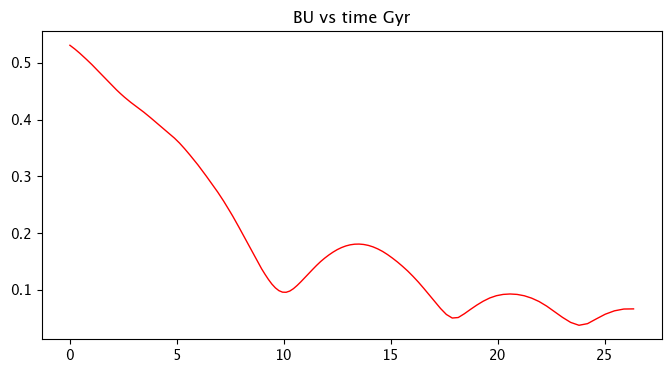

In [10]:
s = np.linalg.norm(positions[:, 0, :] - positions[:, 1, :], axis=1)  # in kpc

plt.figure(figsize=(8, 4))
#plt.plot(t_future_gyr, separations, '.', color='red', markersize=5)
plt.plot(t_future_gyr, s, color='red', lw=1)
plt.title('BU vs time Gyr')
plt.show()

## proper coordinate

In [12]:
z_series = np.insert(z_out, 0, 0)
a_series = 1 / (1+z_series)
pos_kpc = np.zeros(np.shape(pos_co_kpc))
com_pos = np.zeros(np.shape(com_co_pos))
for i in range(0, len(a_series)):
    for j in (0, 1):
        pos_kpc[i, j] = pos_co_kpc[i, j] * a_series[i]
    mtot = m_M31 + m_MW
    com_pos[i] = pos_kpc[i, 0,:] * m_MW/mtot + pos_kpc[i, 1,:] * m_M31/mtot 

boxlim_proper = np.max(pos_kpc) + 100

def update(i):
    ax.clear()
    ax.set_xlim(0, boxlim_proper)
    ax.set_ylim(0, boxlim_proper)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")
    ax.grid(True, linestyle='--', alpha=0.3)
    if i == 0:
        ax.set_title(f"Step {i}: z=0.0, year={t_future_gyr[i]:.2f} Gyr")
    else:
        ax.set_title(f"Step {i}: z={z_out[i-1]:.2f}, year={t_future_gyr[i]:.2f} Gyr")
    for pid in range(2):
        n = 0
        #ax.scatter(pos_co_kpc[i, pid, 0], pos_co_kpc[i, pid, 1], color=colors[pid], s=50)
        ax.scatter(pos_kpc[i, pid, 0], pos_kpc[i, pid, 1], color=colors[pid], s=50)
        ax.scatter(com_pos[i, 0], com_pos[i, 1], color='green', s=50)
        if n == 0:
            ax.legend(['MW', 'com', 'M31'])
        n += 1

ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=50)
ani.save(f"{path}/trajectory_proper.gif", writer="pillow")
plt.close()

## Seperation vs time: r(t)

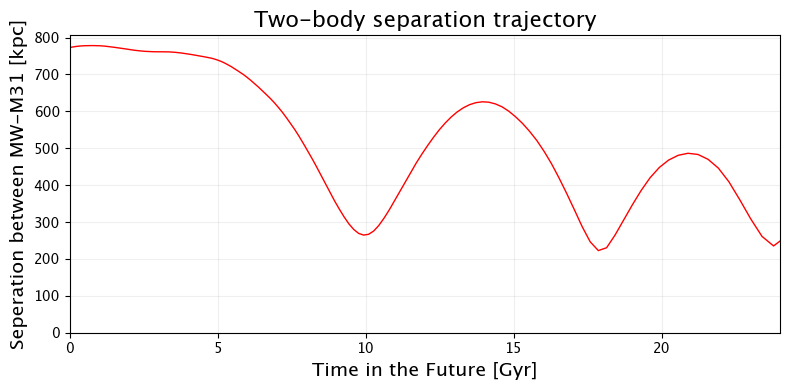

In [13]:
separations = np.linalg.norm(pos_kpc[:, 0, :] - pos_kpc[:, 1, :], axis=1)  # in kpc

plt.figure(figsize=(8, 4))
#plt.plot(t_future_gyr, separations, '.', color='red', markersize=5)
plt.plot(t_future_gyr, separations, color='red', lw=1)
plt.xlabel("Time in the Future [Gyr]", fontsize=14)
plt.ylabel("Seperation between MW-M31 [kpc]", fontsize=14)
plt.title("Two-body separation trajectory", fontsize=16)
plt.xlim(0, 24)
plt.ylim(0)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(f"{path}/trajectory_separation.png", dpi=300)
plt.show()

## Check angular momentum L conservation in two-body system
$\vec{L} = \mu \vec{r} \times \vec{v_{pec}}$, where $\mu=\frac{m_1m_2}{m_1+m_2}$ and $\vec{v_{pec}} = \vec{\dot{r}} -H\vec{r}$

But in a two-body system, relative form can be written as $\vec{r} = \vec{r_1}-\vec{r_2}$ and $\vec{v_{pec, rel}}=\vec{v_{1, pec}}-\vec{v_{2, pec}}$

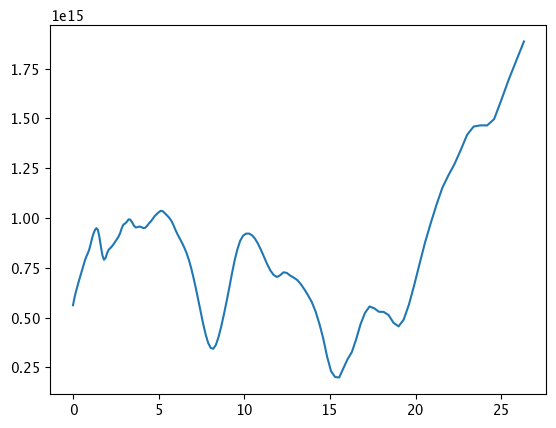

In [45]:
# Load velocity in BU/BU time
velocities = []
for snap in snapshots:
    df = pd.read_parquet(snap)
    vel = df[["vx", "vy", "vz"]].values  # shape (2, 3)
    velocities.append(vel)
velocities = np.array(velocities)  # shape: (n_snapshots, 2, 3)

# convert velocity from BU/BU time to km/s
conversion = a_series / 100 / boxlen
vel_pec = np.zeros(np.shape(velocities))
for i in (0, 1):
    for j in (0, 1, 2):
        vel_pec[:, i, j] = velocities[:, i, j] / conversion # in kpc/Gyr

# relative version
mu = m_M31*m_MW/mtot
vel_pec *= 0.977792221 # km/s
v_rel_pec = vel_pec[:, 0, :] - vel_pec[:, 1, :]
r12 = pos_kpc[:, 0, :] - pos_kpc[:, 1, :]
L_vec = mu * np.cross(r12, v_rel_pec) # Msun kpc km/s
L = np.linalg.norm(L_vec, axis=1)
plt.plot(t_future_gyr, L)

# Check the cosmotable with theory

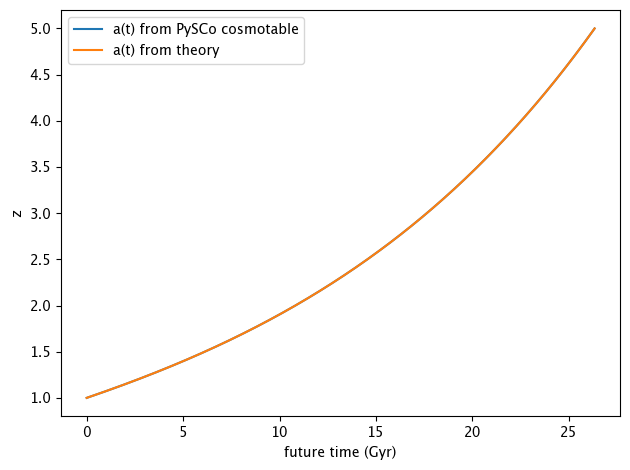

In [52]:
aexp, E, t_supercomoving, *_ = np.loadtxt('mw_m31/simple/evolution_table_pysco.txt', skiprows=1, unpack=1)


def plot_cosmo_table(a, E, om_m, future=True):
    z = 1.0/a - 1.0
    lna = np.log(a)

    # Proper time in Gyr with t(a=1)=0 (lookback sign convention)
    H0_si = 70 / (1e3 * pc.value)     # s^-1
    sec_per_Gyr = 3.15576e16

    # t(a) = (1/H0) * ∫ d ln a / E(a)
    t_times_H0 = cumulative_trapezoid(1.0 / E, lna, initial=0.0)  # dimensionless
    # Anchor so that t(a=1) = 0 exactly
    t_times_H0 -= np.interp(0.0, lna, t_times_H0)
    t_Gyr = (t_times_H0 / H0_si) / sec_per_Gyr  # seconds -> Gyr

    if future:
        plt.plot(t_Gyr[t_Gyr>0], a[t_Gyr>0], label=f'a(t) from PySCo cosmotable')
        #aexp, E_array, t_future_gyr = compute_future_cosmo(t_future_max_gyr=t_future_max_gyr)
        #z = 1.0/np.asarray(aexp) - 1.0
        #plt.plot(t_future_gyr, aexp, label=f'a(t) from model')
        plt.xlabel('future time (Gyr)')
    else:
        plt.plot(t_Gyr[t_Gyr<0], z[t_Gyr<0], label=f'z(t) from cosmo table (with om_r at early t)')
        cosmic_time = np.linspace(0, 14, 50)
        z = np.zeros(len(cosmic_time))
        for i in range(0, len(cosmic_time)):
            z[i] = z_from_time(cosmic_time[i], om_m)
        plt.plot(cosmic_time-14, z, label=f'z(t) from model (om_m={om_m:.3f})')
        plt.xlabel('lookback time (Gyr)')
    plt.ylabel('z')
    #plt.legend()
    #plt.tight_layout()
    #plt.show()

plot_cosmo_table(aexp, E, Om_m, future=True)
plt.plot(t_Gyr-t0, a_grid, label='a(t) from theory')
#plot_cosmo_table(aexp, E, Om_m, future=False)
plt.legend()
plt.tight_layout()
plt.show()